# Model Setup

In [1]:
import numpy as np

np.seterr(divide = 'ignore')
def layer(dim_in,dim_out, activation):
    # dictionary to hold all the different attributes for a layer
    layer = {}
    
    # number weights is = number of neurons in the previos layer * number of neurons in this layer
    # initialised as random floats from -1 -> 1 
    layer['weights'] = 0.1*np.random.randn(dim_in, dim_out)
    
    # One Bias for each neuron
    layer['biases'] = np.zeros((1,dim_out))
    
    # Activation function for this layer (if Linear then no effect, one to one linear mapping)
    layer['activation'] = activation
    
    # Initialise momentums and caches as zero
    layer['mweight'] = np.zeros_like(layer['weights'])
    layer['cweight'] = np.zeros_like(layer['weights'])
    layer['mbias'] = np.zeros_like(layer['biases'])
    layer['cbias'] = np.zeros_like(layer['biases'])
        
    return layer


def forward_layer(layer, inputs):
    # Save inputs for later backpropogation
    layer['inputs'] = inputs
    
    # Calculate output of each neuron in the layer
    layer['outputs'] = np.dot(layer['inputs'],layer['weights']) + layer['biases']
    
    # Impose activation if available
    if layer['activation'] == 'Relu':
        
        layer['activation_inputs'] = layer['outputs']
        
        # Non linear Relu Activation
        layer['activation_outputs'] = np.maximum(0,layer['outputs'])
        
    return layer


def backward_layer(layer, backprop):
    
    # Values from previous layer back propogated (loss function values for the final layer)
    layer['backprop_inputs'] = backprop.copy()
    
    # Work backwards to get Relu values
    if layer['activation'] == 'Relu':
        layer['backprop_inputs'][layer['activation_inputs'] <= 0] = 0
   
    # Backprop weights and biases changes, derived from partial derivatives as in paper
    layer['bweights'] = np.dot(layer['inputs'].T, layer['backprop_inputs'])
    layer['bbiases'] = np.sum(layer['backprop_inputs'],axis = 0, keepdims = True)
    layer['backprop_inputs'] = np.dot(layer['backprop_inputs'], layer['weights'].T)
    
    
        
    return layer

def loss_forward(prediction, desired):
    # Calculate loss on the forward pass
    return np.mean(np.mean((prediction-desired)**2, axis = 1))

def loss_backward(backprop,desired):
    # Calculate partial derivative of loss with respect to output, as in paper
    return (-2*(desired - backprop)/ len(backprop[0]))/len(backprop)
        

# Set Adam Optimizer Hyperparamters
def optimizer_setup(A,A_decay):
    optimizer = {}
    
    # Alpha (ie learning rate)
    optimizer['A'] = A
    
    # Alpha correct
    optimizer['A_decay'] = A_decay
     
    # Beta 1 and 2
    optimizer['B1'] = 0.9
    optimizer['B2'] = 0.999
    
    return optimizer
        
# Adamn Method for Optimization Schochastic Gradient Descent
def optimizer_adjust(optimizer, layer):
    
    # Momentums of weights and biases
    layer['mweight'] = optimizer['B1'] * layer['mweight'] + (1 - optimizer['B1']) * layer['bweights']
    layer['mbias'] = optimizer['B1'] * layer['mbias'] + (1 - optimizer['B1']) * layer['bbiases']
    
    # Adjustement and correct of momentum of weights and biases
    mweight_corrected = layer['mweight'] / (1 - optimizer['B1'] ** (optimizer['epoch'] + 1))
    mbias_corrected = layer['mbias'] / (1 - optimizer['B1'] ** (optimizer['epoch'] + 1))

    # Cache of weight and biases
    layer['cweight'] = optimizer['B2'] * layer['cweight'] + (1 - optimizer['B2']) * layer['bweights']**2
    layer['cbias'] = optimizer['B2'] * layer['cbias'] + (1 - optimizer['B2']) * layer['bbiases']**2

    # Adjustement and correct of cache of weights and biases
    cweight_corrected = layer['cweight'] / (1 - optimizer['B2'] ** (optimizer['epoch'] + 1))
    cbias_corrected = layer['cbias'] / (1 - optimizer['B2'] ** (optimizer['epoch'] + 1))

    # Adjust weights and biases 
    layer['weights'] += -optimizer['A'] * mweight_corrected / (np.sqrt(cweight_corrected) + 1e-8)
    layer['biases'] += -optimizer['A'] * mbias_corrected / (np.sqrt(cbias_corrected) + 1e-8)
    
    return layer


# Data generation and training of model to perform root finding

In [24]:
import numpy as np

np.random.seed(42)


def generate_data(num_samples):
    X = []
    y = []
    for _ in range(num_samples):
        sign = sign2 = -1
        if np.random.randint(2) == 1:
            sign = 1
        if np.random.randint(2) == 1:
            sign2 = 1

        a = sign2 * np.random.randint(100)
        b = np.random.randint(100)
        c = sign * np.random.randint(100)

        sol = np.roots([a, b, c])
        sol = np.array([i for i in sol if i.imag == 0])
        if sol.any():
            X.append([a, b, c])
            y.append([max(sol)])

    return np.array(X), np.array(y)


def print_training_progress(epoch, accuracy, loss):
    print(f'Epoch: {epoch}, Accuracy: {accuracy:.4f}, Loss: {loss:.10f}')


def calculate_accuracy(predictions, targets):
    accuracies = np.abs((targets - predictions) / targets) * 100
    accuracies = [acc for acc in accuracies.flatten() if not np.isinf(acc) and acc < 500]
    off_point = np.mean(accuracies)
    if off_point > 100:
        accuracy = 0
    else:
        accuracy = 100 - off_point
    return accuracy


# Generate training data
X, y = generate_data(3000)

# Generate testing data
X_test, y_test = generate_data(1000)

# Initialize layers of the neural network
layer1 = layer(3, 64, 'Relu')
layer2 = layer(64, 64, 'Relu')
layer3 = layer(64, 1, 'Linear')

# Set the learning rate and optimizer parameters
A = 0.01
optimizer = optimizer_setup(A, 1e-3)
optimizer['epoch'] = 0


# Initialize lists to store accuracy and loss values
train_accuracy_history = []
train_loss_history = []
test_accuracy_history = []
test_loss_history = []


# Training loop
for epoch in range(10000):
    # Forward pass
    layer1 = forward_layer(layer1, X)
    layer2 = forward_layer(layer2, layer1['activation_outputs'])
    layer3 = forward_layer(layer3, layer2['activation_outputs'])
    loss = loss_forward(layer3['outputs'], y)



    # Backward pass
    backprop = loss_backward(layer3['outputs'], y)
    layer3 = backward_layer(layer3, backprop)
    layer2 = backward_layer(layer2, layer3['backprop_inputs'])
    layer1 = backward_layer(layer1, layer2['backprop_inputs'])

    # Optimize weights and biases using Adam optimizer
    optimizer['A'] = A * (1 / (1 + optimizer['A_decay'] * optimizer['epoch']))
    layer1 = optimizer_adjust(optimizer, layer1)
    layer2 = optimizer_adjust(optimizer, layer2)
    layer3 = optimizer_adjust(optimizer, layer3)
    optimizer['epoch'] = epoch + 1

    if epoch % 500 == 0:
        accuracy = calculate_accuracy(layer3['outputs'], y)
        print_training_progress(epoch, accuracy, loss)
        # Store training accuracy and loss
        train_accuracy_history.append(accuracy)
        train_loss_history.append(loss)




        # Forward pass on test set
        layer1_test = forward_layer(layer1, X_test)
        layer2_test = forward_layer(layer2, layer1_test['activation_outputs'])
        layer3_test = forward_layer(layer3, layer2_test['activation_outputs'])
        loss_test = loss_forward(layer3_test['outputs'], y_test)

        # Calculate test accuracy
        accuracy_test = calculate_accuracy(layer3_test['outputs'], y_test)

        # Store test accuracy and loss
        test_accuracy_history.append(accuracy_test)
        test_loss_history.append(loss_test)

Epoch: 0, Accuracy: 0.0000, Loss: 54.0832467355
Epoch: 500, Accuracy: 59.3622, Loss: 0.1481434174
Epoch: 1000, Accuracy: 82.2085, Loss: 0.0419122467
Epoch: 1500, Accuracy: 87.4730, Loss: 0.0242434180
Epoch: 2000, Accuracy: 89.7666, Loss: 0.0157062545
Epoch: 2500, Accuracy: 89.5999, Loss: 0.0121018563
Epoch: 3000, Accuracy: 91.8109, Loss: 0.0079250909
Epoch: 3500, Accuracy: 91.8072, Loss: 0.0060551417
Epoch: 4000, Accuracy: 92.9171, Loss: 0.0048366586
Epoch: 4500, Accuracy: 89.7854, Loss: 0.0045988755
Epoch: 5000, Accuracy: 93.7915, Loss: 0.0031327900
Epoch: 5500, Accuracy: 94.3034, Loss: 0.0026866039
Epoch: 6000, Accuracy: 94.2509, Loss: 0.0024477902
Epoch: 6500, Accuracy: 92.5320, Loss: 0.0025155383
Epoch: 7000, Accuracy: 94.8189, Loss: 0.0018428145
Epoch: 7500, Accuracy: 94.9697, Loss: 0.0016735660
Epoch: 8000, Accuracy: 95.2369, Loss: 0.0016656701
Epoch: 8500, Accuracy: 91.0188, Loss: 0.0030794841
Epoch: 9000, Accuracy: 95.2503, Loss: 0.0015545438
Epoch: 9500, Accuracy: 95.3022, Los

# Accuracy on test set

In [13]:
import pandas as pd
import numpy as np

# Forward pass of test values through the neural network
layer1 = forward_layer(layer1, X_test)
layer2 = forward_layer(layer2, layer1['activation_outputs'])
layer3 = forward_layer(layer3, layer2['activation_outputs'])

# Calculate test accuracy
y_flat = y_test.flatten()
pred_flat = layer3['outputs'].flatten()
accuracies = [abs((y_flat[i] - pred_flat[i]) / y_flat[i]) * 100 for i in range(len(y_flat))]
off_point = np.mean([i for i in accuracies if i != np.inf and i < 500])

# If prediction is more than twice the value of the desired output, accuracy is 0 percent
if off_point > 100:
    accuracy = 0
else:
    accuracy = 100 - off_point

print('Accuracy on test set:', accuracy)

# Print test values and predicted values side by side to assess model accuracy
test = pd.DataFrame()
test['Solution Real Numpy Test Set'] = [str(i)[:5] for i in y_test.flatten()]
test['Solution Real Model Test Set'] = [str(i)[1:6] for i in layer3['outputs']]

test


Accuracy on test set: 93.24359681312075


,Solution Real Numpy Test Set,Solution Real Model Test Set
0,1.999,2.051
1,2.217,2.221
2,4.142,4.111
3,-0.29,-0.28
4,0.839,0.820
...,...,...
638,0.790,0.796
639,-0.02,-0.02
640,12.45,12.19
641,0.271,0.233


# Example of 50 test points and their outputs graphed

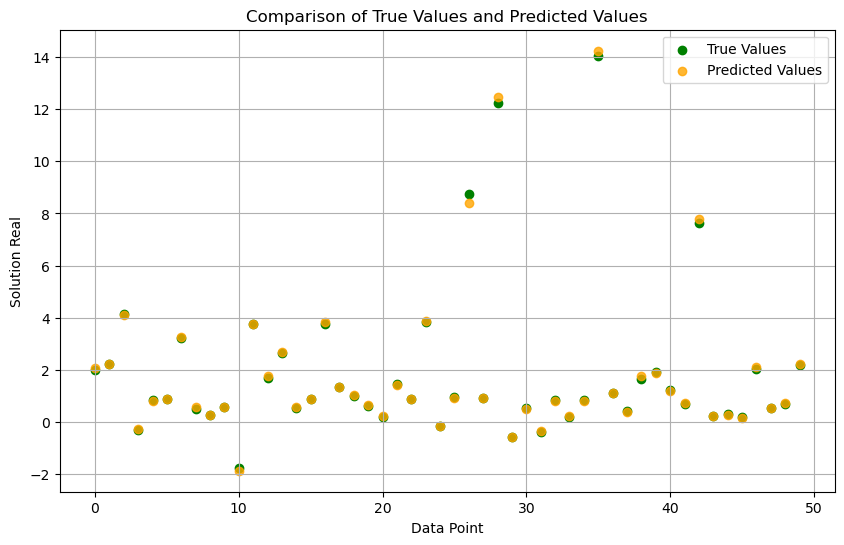

In [18]:
import matplotlib.pyplot as plt

# Forward pass of test values through the neural network
layer1 = forward_layer(layer1, X_test[:50])
layer2 = forward_layer(layer2, layer1['activation_outputs'])
layer3 = forward_layer(layer3, layer2['activation_outputs'])

# Calculate test accuracy
y_flat = y_test[:50].flatten()
pred_flat = layer3['outputs'].flatten()
accuracies = [abs((y_flat[i] - pred_flat[i]) / y_flat[i]) * 100 for i in range(len(y_flat))]
off_point = np.mean([i for i in accuracies if i != np.inf and i < 500])

# If prediction is more than twice the value of the desired output, accuracy is 0 percent
if off_point > 100:
    accuracy = 0
else:
    accuracy = 100 - off_point


# Visualize the predicted values and true values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_flat)), y_flat, label='True Values', color = 'green')
plt.scatter(range(len(pred_flat)), pred_flat, label='Predicted Values', color = 'orange', alpha = 0.8)
plt.xlabel('Data Point')
plt.ylabel('Solution Real')
plt.grid()
plt.title('Comparison of True Values and Predicted Values')

plt.legend()
plt.show()


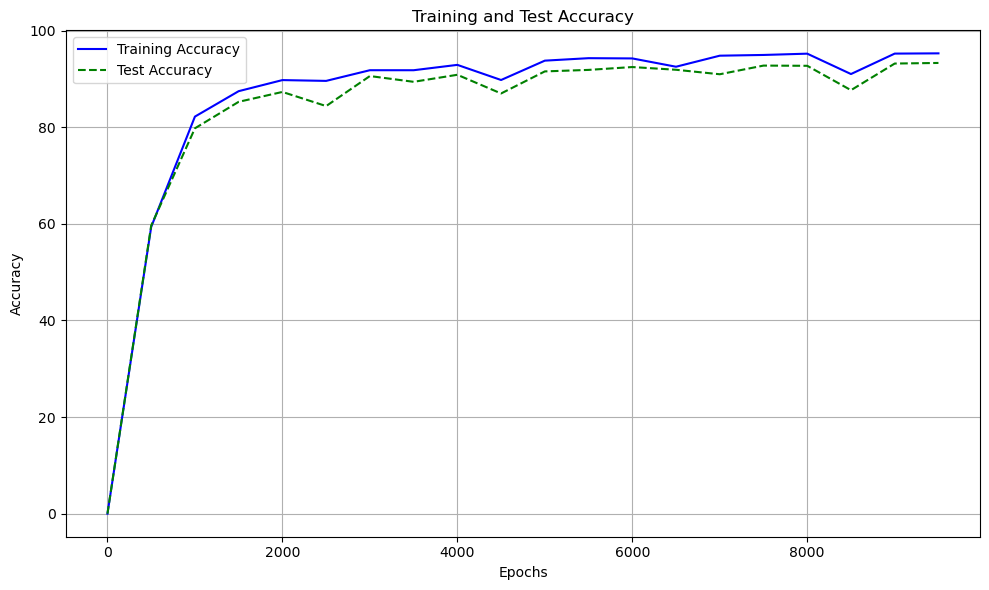

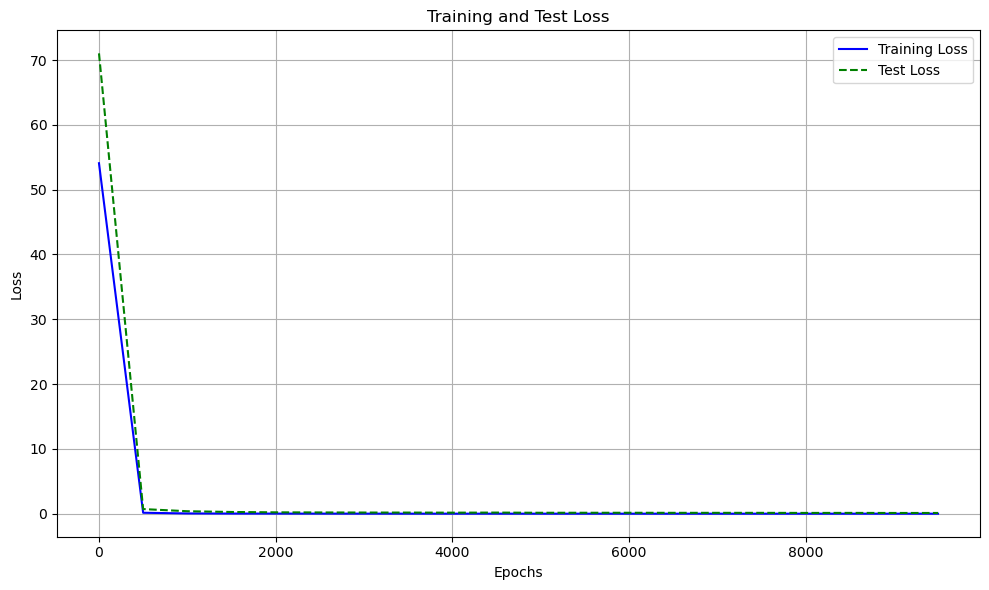

In [28]:
# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy_history, label='Training Accuracy', color='blue', linestyle='-')
plt.plot(epochs, test_accuracy_history, label='Test Accuracy', color='green', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_history, label='Training Loss', color='blue', linestyle='-')
plt.plot(epochs, test_loss_history, label='Test Loss', color='green', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()